In [320]:
import pandas as pd
from pandas.io import sql
import sqlite3
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import tree
%matplotlib inline

Read csv

In [329]:
df = pd.read_csv('~/Downloads/employee_retention_data.csv')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


Use SQL-do this later

In [34]:
conn = sqlite3.connect('employee.db')
conn.text_factory = str
cur = conn.cursor()
cur.execute('CREATE TABLE data (employee_id INTEGER, company_id INTEGER, seniority INTEGER, salary INTEGER, join_date TEXT, quit_date TEXT);')

In [37]:
with open('Downloads/employee_retention_data.csv','r') as fname:
    dr = csv.DictReader(fname)
    to_db = [(i['employee_id'],i['company_id'], i['dept'], i['seniority'], i['salary'], i['join_date'], i['quit_date']) \
             for i in dr]

cur.executemany("INSERT INTO data (employee_id, company_id, dept, seniority, salary, join_date, quit_date) \
                VALUES (?, ?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

In [39]:
conn = sqlite3.connect('employee.db')
c = conn.cursor()
c.execute("SELECT employee_id FROM data").fetchall()

In [43]:
df2 = sql.read_sql('select * from data', conn)
df2.head()

,employee_id,company_id,seniority,salary,join_date,quit_date
0,7,customer_service,28,89000,2014-03-24,2015-10-30
1,7,marketing,20,183000,2013-04-29,2014-04-04
2,4,marketing,14,101000,2014-10-13,NA
3,7,customer_service,20,115000,2012-05-14,2013-06-07
4,2,data_science,23,276000,2011-10-17,2014-08-22


### Create table of company, date, employee count

In [124]:
dates = pd.date_range(start='2011/01/24',end='2015/12/13')
temp = {'date':dates}
temp = pd.DataFrame(data=temp)
temp['key']=0

In [125]:
unique_companies = df.company_id.unique()
temp1 = {'company_id':unique_companies}
temp1 = pd.DataFrame(data=temp1)
temp1['key']=0

Cartesian product

In [126]:
merged = pd.merge(temp, temp1,on='key')
merged.drop('key',1, inplace=True)

In [127]:
merged.head()

,date,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [167]:
join_by_day = df.groupby(['company_id','join_date'])['company_id','join_date'].sum()
join_by_day.columns = ['number_quit']
join_by_day.reset_index(inplace=True)
join_by_day.columns = ['company_id','date','number_join']
join_by_day['date'] = pd.to_datetime(join_by_day['date'])
join_by_day.head()

,company_id,date,number_join
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [143]:
quit_by_day = df.groupby(['company_id','quit_date'])[['company_id','quit_date']].sum()
quit_by_day.columns = ['number_quit']
quit_by_day.reset_index(inplace=True)
quit_by_day.columns = ['company_id','date','number_quit']
quit_by_day['date'] = pd.to_datetime(quit_by_day['date'])
quit_by_day.head()

,company_id,date,number_quit
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [169]:
test=pd.merge(merged,quit_by_day,left_on=['company_id','date'],right_on=['company_id','date'],how='left').fillna(0)
sum(test['number_quit'])

46738.0

In [177]:
test2=pd.merge(test,join_by_day,left_on=['company_id','date'],right_on=['company_id','date'],how='left').fillna(0)

In [178]:
test2['employee_count'] = test2['number_join']-test2['number_quit']

In [180]:
test2.drop(['number_quit','number_join'],1, inplace=True)

,date,company_id,employee_count
0,2011-01-24,7,7.0
1,2011-01-24,4,48.0
2,2011-01-24,2,34.0
3,2011-01-24,9,27.0
4,2011-01-24,1,25.0
5,2011-01-24,6,18.0
6,2011-01-24,10,0.0
7,2011-01-24,5,25.0
8,2011-01-24,3,27.0
9,2011-01-24,8,48.0


In [219]:
employee_count_table=test2.groupby(['date','company_id']).sum().groupby(['company_id']).cumsum()
employee_count_table.reset_index(inplace=True)
employee_count_table.head()

,date,company_id,employee_count
0,2011-01-24,1,25.0
1,2011-01-24,2,34.0
2,2011-01-24,3,27.0
3,2011-01-24,4,48.0
4,2011-01-24,5,25.0
5,2011-01-24,6,18.0
6,2011-01-24,7,7.0
7,2011-01-24,8,48.0
8,2011-01-24,9,27.0
9,2011-01-24,10,0.0


### Explore the distributions of length of employment and weeks of year when employees quit

In [330]:
length=pd.to_datetime(df['quit_date'])-pd.to_datetime(df['join_date'])

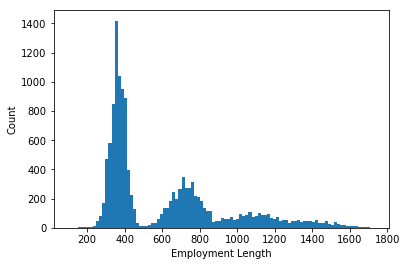

In [331]:
length1=length.apply(lambda x:float(x.days))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Employment Length')
ax.set_ylabel('Count')
ax.hist(length1[np.isfinite(length1)],bins=100)
plt.show()

Around every year (~365 days, 730 days), there are peaks in the number of employees who quit. It seems that people are more likely to quit close to their anniversary. When they get a bonus?

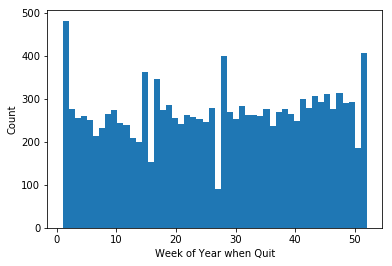

In [332]:
week_of_year = pd.to_datetime(df['quit_date'])
week_of_year = week_of_year.apply(lambda x:float(x.week))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Week of Year when Quit')
ax.set_ylabel('Count')
ax.hist(week_of_year[np.isfinite(week_of_year)],bins=50)
plt.show()

It looks like people are quitting around New Year's. Maybe because they get bonuses then and because it is easier to find a new job since companies have more money to hire at the beginning of the year? 

Add the employment length to the dataframe.

In [333]:
df['length'] = length1
df['length']=df['length'].fillna(-1)

One hot encode the job title.

In [335]:
df_dept = pd.get_dummies(df['dept'])
df = pd.concat([df, df_dept], axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,customer_service,data_science,design,engineer,marketing,sales
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1,0,0,0,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,0,0,0,0,1,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,NaN,0,0,0,0,1,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1,0,0,0,0,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0,1,0,0,0,0


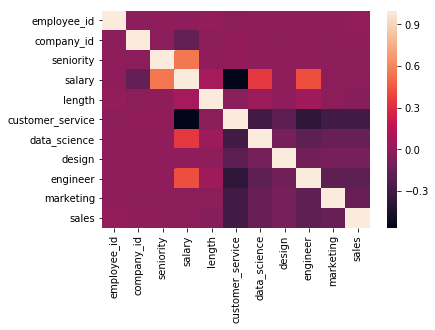

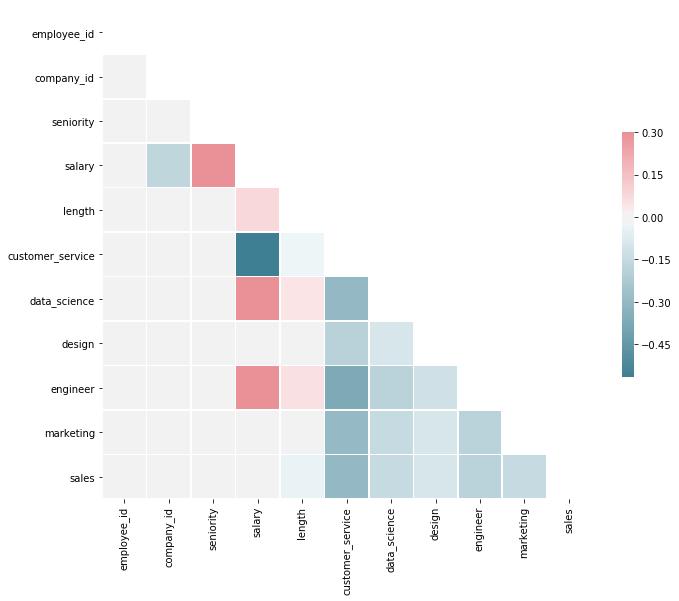

In [338]:
corr = df.corr()
sns.heatmap(corr)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [348]:
def is_employed(row):
    if row['length'] < 396 and row['quit_date'] == row['quit_date']:
        val = 1
    else:
        val = 0
    return val
df['employed'] = df.apply(is_employed,axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,customer_service,data_science,design,engineer,marketing,sales,employed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1,0,0,0,0,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,0,0,0,0,1,0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,NaN,0,0,0,0,1,0,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1,0,0,0,0,0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0,1,0,0,0,0,0


In [349]:
df_for_tree = df[pd.to_datetime(df['join_date'])<pd.to_datetime('2015-12-13')-pd.to_timedelta(396,unit='d')]

In [350]:
X_train, X_test, y_train, y_test = train_test_split( \
df_for_tree[['company_id','customer_service','data_science','design','engineer','marketing','sales','seniority','salary']], df_for_tree['employed'], test_size=0.33, random_state=4)

In [351]:
clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [352]:
accuracy_score(predicted, y_test)

0.599685534591195

In [353]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3) 
graph = graphviz.Source(dot_data) 
graph.render("employee_retention_tree")

'iris.pdf'

Salary is the most important feature, followed by seniority and company. Salary usually depends on seniority, and we saw in the correlation plot that it had a correlation of .3 with seniority.

In [354]:
clf.feature_importances_

array([ 0.21181453,  0.00369063,  0.0180618 ,  0.01189603,  0.01739499,
        0.01217429,  0.01209822,  0.28535312,  0.42751641])

In [366]:
df['salary'].quantile(np.linspace(0.1,0.5,num=5))

0.1     52000.0
0.2     70000.0
0.3     89000.0
0.4    105000.0
0.5    123000.0
Name: salary, dtype: float64

In [367]:
df['salary_percent'] = pd.qcut(df['salary'], 50, labels=False)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,customer_service,data_science,design,engineer,marketing,sales,employed,salary_percent
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1,0,0,0,0,0,0,14
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,0,0,0,0,1,0,1,36
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,NaN,0,0,0,0,1,0,0,18
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1,0,0,0,0,0,1,22
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0,1,0,0,0,0,0,46


In [368]:
df.groupby(['salary_percent'])['employed'].sum()

salary_percent
0     102
1      97
2     103
3      97
4      89
5     115
6     105
7     119
8     115
9     100
10     92
11    145
12    112
13    122
14    129
15    111
16    157
17    107
18    105
19    135
20    161
21    122
22    120
23    126
24    137
25    101
26    176
27    146
28    154
29    117
30    161
31    136
32    112
33    151
34    104
35    137
36    116
37    126
38    112
39    103
40    126
41    117
42    108
43     83
44     96
45     74
46     70
47     65
48     55
49     46
Name: employed, dtype: int64

In [370]:
percentiles = df.groupby('salary_percent')['employed'].agg(['sum','count'])
percentiles['percent'] = percentiles['sum']/percentiles['count']
percentiles.head()

,sum,count,percent
salary_percent,,,
0,102,531,0.192090
1,97,500,0.194000
2,103,462,0.222944
3,97,506,0.191700
4,89,473,0.188161


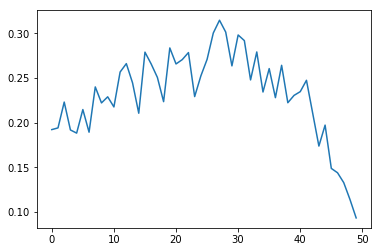

In [372]:
plt.plot(percentiles.index,percentiles['percent'])